# 🈯 Fluency Evaluation - ACL2024

## ⬇️ Imports

In [1]:
import pandas as pd
import numpy as np
import scipy.optimize as opt
import os
import json
from transformers import pipeline
import evaluate
import torch

## 💾 Load Data

Load order of sentences

In [2]:
with open("data/claim-extraction-acl24/sentence_order.json", "r") as f:
    sentence_order = json.loads(f.readline())

display(sentence_order)

[6140,
 4799,
 4773,
 617,
 5387,
 4295,
 4304,
 134,
 5647,
 3275,
 5983,
 942,
 5321,
 4831,
 1702,
 3102,
 3994,
 1771,
 2136,
 1637,
 4376,
 1326,
 4109,
 2720,
 5883,
 1394,
 734,
 5182,
 3745,
 1317,
 6593,
 2419,
 3092,
 3153,
 1361,
 3220,
 4969,
 1242,
 4276,
 2707,
 3138,
 138,
 5113,
 5967,
 5868,
 2328,
 605,
 3115,
 5027,
 2950,
 1538,
 3447,
 3150,
 3809,
 1007,
 3631,
 4056,
 1029,
 5856,
 1913,
 5838,
 438,
 4727,
 3908,
 741,
 467,
 4206,
 693,
 638,
 2455,
 554,
 295,
 6093,
 5532,
 3326,
 3590,
 4982,
 6316,
 917,
 2204,
 1673,
 889,
 108,
 4251,
 2427,
 5670,
 5086,
 2273,
 5811,
 4145,
 1844,
 3539,
 305,
 515,
 12,
 3721,
 3508,
 5865,
 948,
 4393,
 1838,
 5469,
 343,
 795,
 5957,
 5536,
 1150,
 785,
 1404,
 4387,
 1994,
 227,
 3090,
 4223,
 6405,
 1859,
 5712,
 2332,
 3589,
 4324,
 3690,
 1211,
 318,
 1076,
 3470,
 1705,
 5708,
 3663,
 284,
 147,
 6198,
 606,
 3992,
 5565,
 2837,
 2238,
 1293,
 2721,
 1716,
 2894,
 1981,
 3769,
 64,
 6257,
 159,
 2263,
 4103,
 27

In [3]:
DATA_PATH = "data/claim-extraction-acl24/fluency/"
MODELS = ["gpt-4-turbo-3-shot.jsonl", 
              "qacg.jsonl",
              "qlora-mistral-instruct-v0.2.jsonl",
              "t5_small_diverse_7_beam_search.jsonl",
              "t5_small_multiclaim.jsonl"]


Load Dataframes

In [ ]:

data = {}
for model in MODELS:
    path = os.path.join(DATA_PATH, model)

    claims = []
    #open file of one model
    with open(path, "r") as f:
        #read one line (consists of more claims)
        for line in f:
            claims.append(json.loads(line))
    
    data[model] = claims


display(data.keys())
display(data['gpt-4-turbo-3-shot.jsonl'])

dict_keys(['gpt-4-turbo-3-shot.jsonl', 'qacg.jsonl', 'qlora-mistral-instruct-v0.2.jsonl', 't5_small_diverse_7_beam_search.jsonl', 't5_small_multiclaim.jsonl'])

[['R. Kelly was nominated for a Grammy in 1996.',
  "R. Kelly wrote Michael Jackson's song 'You Are Not Alone'.",
  'R. Kelly released collaboration albums with Jay-Z in 2002 and 2004.',
  'R. Kelly has been a guest vocalist for Nas.',
  'R. Kelly has been a guest vocalist for Sean Combs.',
  'R. Kelly has been a guest vocalist for The Notorious B.I.G.',
  'The RIAA has recognized R. Kelly as one of the best-selling music artists in the United States.',
  'R. Kelly has sold 40 million albums in the United States.',
  "R. Kelly is the fifth black artist to crack the top 50 of the RIAA's list.",
  'Billboard named R. Kelly the most successful R&B artist of the last 25 years in March 2011.'],
 ['Greenpeace is a non-governmental environmental organization.',
  'Greenpeace has offices in over 40 countries.',
  'Greenpeace has an international coordinating body in Amsterdam.',
  'Greenpeace was founded in 1971.',
  'Greenpeace was founded by Canadian and US ex-pat environmental activists.',


Convert to Dataframe

In [5]:
res_claims = []

for model in MODELS:
    for idx, claims in zip(sentence_order, data[model]):
        for claim in claims:
            res_claims.append([model[:-6], idx, claim])

df = pd.DataFrame(res_claims, columns=["model", "sentence_id", "generated"])
display(df.head())
display(df.sample(10))


,model_name,sentence_id,claim
0,gpt-4-turbo-3-shot,6140,R. Kelly was nominated for a Grammy in 1996.
1,gpt-4-turbo-3-shot,6140,R. Kelly wrote Michael Jackson's song 'You Are...
2,gpt-4-turbo-3-shot,6140,R. Kelly released collaboration albums with Ja...
3,gpt-4-turbo-3-shot,6140,R. Kelly has been a guest vocalist for Nas.
4,gpt-4-turbo-3-shot,6140,R. Kelly has been a guest vocalist for Sean Co...


,model_name,sentence_id,claim
4438,qacg,5883,McDonnell Douglas's other name was MD.
5963,qacg,1141,Winona Ryder was nominated for two Screen Acto...
6779,qacg,232,The Tremont Street Subway connects to Governme...
7596,qacg,4120,Kelly went solo with his album 12 Play in 1993.
10578,qlora-mistral-instruct-v0.2,1101,Back to the Future Part II is an American film.
14070,t5_small_multiclaim,3470,Eric Trump is the son of Ivana Trump.
7886,qacg,5485,Diego Costa played for Brazil in 2013.
9716,qlora-mistral-instruct-v0.2,5712,Prometheus required technology to be developed.
6736,qacg,5396,Hamlet was written in English.
9922,qlora-mistral-instruct-v0.2,4811,Marco Polo was not the first European to reach...


In [5]:
#load from Bertík
df = pd.read_json('/mnt/data/factcheck/_acl24/single_metrics.jsonl', lines=True)
df

,sentence_id,model,generated,F,F_lg,F_bert,D,A,A_luke,annotation,F_gold,G_gold,D_gold,A_gold
0,6140,t5_small_diverse_7_beam_search,R. Kelly is a music artist.,0.997425,0.999607,0.897497,True,True,True,NaN,NaN,NaN,NaN,NaN
1,6140,t5_small_diverse_7_beam_search,R. Kelly has been a guest vocalist for Nas.,0.997547,0.997142,0.872724,False,True,True,NaN,NaN,NaN,NaN,NaN
2,6140,t5_small_diverse_7_beam_search,R. Kelly has released collaboration albums wit...,0.996436,0.998380,0.874548,True,False,True,NaN,NaN,NaN,NaN,NaN
3,6140,t5_small_diverse_7_beam_search,R. Kelly released collaboration albums with Ja...,0.996924,0.997682,0.875569,True,False,True,NaN,NaN,NaN,NaN,NaN
4,6140,t5_small_diverse_7_beam_search,R. Kelly is one of the best-selling music arti...,0.994441,0.994815,0.879582,True,True,True,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15555,3541,t5_small_multiclaim,Adrianne Palicki was born in 1983.,0.997649,0.999215,0.892769,True,True,True,3311.0,1.0,1.0,1.0,1.0
15556,3541,t5_small_multiclaim,Adrianne Palicki is an American.,0.999051,0.999498,0.902723,True,True,True,3311.0,1.0,1.0,1.0,1.0
15557,3541,t5_small_multiclaim,Adrianne Palicki is best known for her role as...,0.998119,0.995047,0.896891,False,True,True,3311.0,1.0,1.0,1.0,1.0
15558,3541,t5_small_multiclaim,Adrianne Palicki is best known for her role in...,0.165706,0.313146,0.898684,False,True,True,1311.0,0.0,1.0,1.0,1.0


## Prepare CoEdIT Rewrites

https://huggingface.co/grammarly/coedit-large

https://aclanthology.org/2023.findings-emnlp.350/

load models (corresponding Huggingface Pipelines)

In [6]:
coedit_l = pipeline("text2text-generation", model="grammarly/coedit-large", tokenizer="grammarly/coedit-large", framework="pt", device=0, batch_size = 128)
coedit_xl = pipeline("text2text-generation", model="grammarly/coedit-xl", tokenizer="grammarly/coedit-xl", framework="pt", device=0, batch_size = 64)

MAX_LEN_COEDIT = 400

create corrections

In [7]:
output_l = coedit_l(df["generated"].to_list(), max_length = MAX_LEN_COEDIT)
df["generated_coedit_l"] = [x["generated_text"] for x in output_l]
output_xl = coedit_xl(df["generated"].to_list(), max_length = MAX_LEN_COEDIT)
df["generated_coedit_xl"]  = [x["generated_text"] for x in output_xl]

save immediate results

In [10]:
df.to_json(os.path.join(DATA_PATH, "fluency_coedit_results.jsonl"), orient="records", lines=True)

load results

In [4]:
df = pd.read_json(os.path.join(DATA_PATH, "fluency_coedit_results.jsonl"), lines=True)

In [5]:
df.head()

,sentence_id,model,generated,F,F_lg,F_bert,D,A,A_luke,annotation,F_gold,G_gold,D_gold,A_gold,generated_coedit_l,generated_coedit_xl
0,6140,t5_small_diverse_7_beam_search,R. Kelly is a music artist.,0.997425,0.999607,0.897497,True,True,True,NaN,NaN,NaN,NaN,NaN,R. Kelly is a musician.,R. Kelly is a popular music artist.
1,6140,t5_small_diverse_7_beam_search,R. Kelly has been a guest vocalist for Nas.,0.997547,0.997142,0.872724,False,True,True,NaN,NaN,NaN,NaN,NaN,R. Kelly has been a vocalist for Nas.,R. Kelly has been a guest vocalist for Nas.
2,6140,t5_small_diverse_7_beam_search,R. Kelly has released collaboration albums wit...,0.996436,0.998380,0.874548,True,False,True,NaN,NaN,NaN,NaN,NaN,R. Kelly has released albums with Jay-Z.,R. Kelly has released albums with Jay-Z.
3,6140,t5_small_diverse_7_beam_search,R. Kelly released collaboration albums with Ja...,0.996924,0.997682,0.875569,True,False,True,NaN,NaN,NaN,NaN,NaN,R. Kelly released an album with Jay-Z.,R. Kelly has collaborated with Jay-Z on two al...
4,6140,t5_small_diverse_7_beam_search,R. Kelly is one of the best-selling music arti...,0.994441,0.994815,0.879582,True,True,True,NaN,NaN,NaN,NaN,NaN,R. Kelly is a singer of country music. SEP> Hi...,R. Kelly is an American singer and songwriter.


## Prepare Perplexities

Compute perplexities of original claims and of CoEdIT rewrites.

In [11]:
perplexity = evaluate.load("perplexity", module_type="metric")

df["pplxt_generated"] = perplexity.compute(model_id='gpt2',predictions=df["generated"])["perplexities"]
df["pplxt_generated_coedit_l"] = perplexity.compute(model_id='gpt2',predictions=df["generated_coedit_l"])["perplexities"]
df["pplxt_generated_coedit_xl"] = perplexity.compute(model_id='gpt2',predictions=df["generated_coedit_xl"])["perplexities"]


  0%|          | 0/973 [00:00<?, ?it/s]

  0%|          | 0/973 [00:00<?, ?it/s]

  0%|          | 0/973 [00:00<?, ?it/s]

In [12]:
df.to_json(os.path.join(DATA_PATH, "fluency_pplxt_results.jsonl"), orient="records", lines=True)

In [4]:
df = pd.read_json(os.path.join(DATA_PATH, "fluency_pplxt_results.jsonl"), lines=True)
df

,sentence_id,model,generated,F,F_lg,F_bert,D,A,A_luke,annotation,F_gold,G_gold,D_gold,A_gold,generated_coedit_l,generated_coedit_xl,pplxt_generated,pplxt_generated_coedit_l,pplxt_generated_coedit_xl
0,6140,t5_small_diverse_7_beam_search,R. Kelly is a music artist.,0.997425,0.999607,0.897497,True,True,True,NaN,NaN,NaN,NaN,NaN,R. Kelly is a musician.,R. Kelly is a popular music artist.,88.827202,67.630684,79.406815
1,6140,t5_small_diverse_7_beam_search,R. Kelly has been a guest vocalist for Nas.,0.997547,0.997142,0.872724,False,True,True,NaN,NaN,NaN,NaN,NaN,R. Kelly has been a vocalist for Nas.,R. Kelly has been a guest vocalist for Nas.,63.083439,76.761597,63.075047
2,6140,t5_small_diverse_7_beam_search,R. Kelly has released collaboration albums wit...,0.996436,0.998380,0.874548,True,False,True,NaN,NaN,NaN,NaN,NaN,R. Kelly has released albums with Jay-Z.,R. Kelly has released albums with Jay-Z.,79.858452,84.100304,84.100304
3,6140,t5_small_diverse_7_beam_search,R. Kelly released collaboration albums with Ja...,0.996924,0.997682,0.875569,True,False,True,NaN,NaN,NaN,NaN,NaN,R. Kelly released an album with Jay-Z.,R. Kelly has collaborated with Jay-Z on two al...,117.868538,65.561783,39.236511
4,6140,t5_small_diverse_7_beam_search,R. Kelly is one of the best-selling music arti...,0.994441,0.994815,0.879582,True,True,True,NaN,NaN,NaN,NaN,NaN,R. Kelly is a singer of country music. SEP> Hi...,R. Kelly is an American singer and songwriter.,16.624537,32.876286,16.860781
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15555,3541,t5_small_multiclaim,Adrianne Palicki was born in 1983.,0.997649,0.999215,0.892769,True,True,True,3311.0,1.0,1.0,1.0,1.0,She was born in 1983.,She was born in 1983.,18.963940,41.039021,41.039127
15556,3541,t5_small_multiclaim,Adrianne Palicki is an American.,0.999051,0.999498,0.902723,True,True,True,3311.0,1.0,1.0,1.0,1.0,Adrianne Palicki is an American actress. She i...,Adrianne Palicki is an American actor.,23.555801,9.417844,18.124359
15557,3541,t5_small_multiclaim,Adrianne Palicki is best known for her role as...,0.998119,0.995047,0.896891,False,True,True,3311.0,1.0,1.0,1.0,1.0,She is best known for her role as Tyra Collette.,She is known for her role as Tyra Collette.,19.013100,29.682022,50.003304
15558,3541,t5_small_multiclaim,Adrianne Palicki is best known for her role in...,0.165706,0.313146,0.898684,False,True,True,1311.0,0.0,1.0,1.0,1.0,She is best known for her role in Legion.,She is known for her role in Legion.,16.101629,25.121046,47.368946


## 📏 Define Metrics

### Identity Check

Check if senteces fixed by CoEdIT models are the same (no fix needed -> correct)

In [5]:
def identity_check(claim1:str, claim2:str) -> bool:
    return claim1 == claim2

### Levenshtein Distance

In [6]:
import jellyfish

### Levenshtein normalized

In [7]:
def norm_levenshtein_distance(s1:str, s2:str) -> float:
    return jellyfish.levenshtein_distance(s1, s2) / np.max([len(s1), len(s2)])

### Jaccard Similarity

In [8]:
from nltk import ngrams
import re

def jaccard_similarity_ngrams(str1:str, str2: str, N:int, use_regex=True) -> float:
    """
    Computes Jaccard similarity (index) of 2 strings. 
    https://en.wikipedia.org/wiki/Jaccard_index
    """

    if use_regex:
        set1 = set(list(ngrams(re.findall(r"\w+", str1), N)))
        set2 = set(list(ngrams(re.findall(r"\w+", str2), N)))
    else:
        set1 = set(list(ngrams(str1.split(), N)))
        set2 = set(list(ngrams(str2.split(), N)))

    #N-grams cannot be created fallback to 1-grams
    if len(set1) == 0 or len(set2) == 0:
        set1 = set(str1.split())
        set2 = set(str2.split())

    intersection = set1.intersection(set2)
    union = set1.union(set2)
    j_sim = len(intersection)/len(union)

    return j_sim

### Scribendi Score

https://aclanthology.org/2021.emnlp-main.239.pdf

In [9]:
from thefuzz import fuzz
import jellyfish

def lev_dist_ratio(src:str, pred: str) -> float:
    return 1 - (jellyfish.levenshtein_distance(src, pred)/(len(src) + len(pred)))

def scribendi_score(data_line, pred_column:str) -> int:
    src = data_line["generated"]
    pred = data_line[f"generated_{pred_column}"]
    ppl_source = data_line["pplxt_generated"]
    ppl_prediction = data_line[f"pplxt_generated_{pred_column}"]

    if pred == src:
        return 0
    
    if ppl_source <= ppl_prediction:
        return -1
    else:
        tsr = fuzz.token_sort_ratio(src, pred)/100
        ldr = lev_dist_ratio(src, pred)
        if max(tsr, ldr) >= 0.8:
            return 1
        else:
            return -1

### Perplexity Compare

ablation of Scribendi Score

In [10]:
def perplexity_compare(data_line, pred_column:str) -> int:
    ppl_source = data_line["pplxt_generated"]
    ppl_prediction = data_line[f"pplxt_generated_{pred_column}"]

    if ppl_source <= ppl_prediction:
        return -1
    else:
        return 1

### BPESLOR - SLOR (Syntactic Log-Odds Ratio) + BPE

https://aclanthology.org/K18-1031/

We are using GPT2 to predict probabilities. In this case it will be tokenized using GPT2 tokenizer based on byte-level Byte-Pair-Encoding. Our implementation is thus closer to WPSLOR (see paper above) and we call it BPESLOR

In [9]:
import pickle

with open("data/gpt2_counts.pickle", "rb") as f:
    token_counts = pickle.load(f)

num_all_occurences = sum(token_counts.values())
token_frequencies = {k: v / num_all_occurences for k, v in token_counts.items()}

In [10]:
def sentence_log_prob_gpt2(sentence, model, tokenizer, use_gpu = False):
    """
    https://github.com/sgondala/GoogleConceptualCaptioning/blob/master/misc/slor_scoring.py
    """
    tokenize_input = tokenizer.tokenize(sentence)
    # 50256 is the token_id for <|endoftext|>
    tensor_input = torch.tensor([[tokenizer.bos_token_id] + tokenizer.convert_tokens_to_ids(tokenize_input) + [tokenizer.eos_token_id]])

    if use_gpu:
        model = model.to("cuda")
        tensor_input = tensor_input.to("cuda")
    else:
        model = model.to("cpu")

    with torch.no_grad():
        outputs = model(tensor_input, labels=tensor_input)
        _, logits = outputs[:2]
    lp = 0.0
    for i in range(len(tokenize_input)):
        masked_index = i
        predicted_score = logits[0, masked_index]
        assert len(predicted_score.shape) == 1, predicted_score.shape
        # print("Predicted score ", predicted_score)
        # print("Predicted score shape", predicted_score.shape)
        predicted_prob = torch.nn.functional.softmax(predicted_score, dim=0)
        # print("Predicted prob ", predicted_prob)
        # print("predicted prob shape", predicted_prob.shape)
        lp += np.log(predicted_prob[tokenizer.convert_tokens_to_ids([tokenize_input[i]])[0]].cpu())
    return float(lp)

def compute_slor(sentence: str, tokenizer, model, token_frequencies, use_gpu:bool = False):
    """
    https://aclanthology.org/K18-1031.pdf
    https://github.com/huggingface/transformers/issues/920
    https://github.com/huggingface/transformers/issues/477
    https://gist.github.com/yuchenlin/eb63e2d0513f70cfc9bb85fa5a78953b
    https://discuss.huggingface.co/t/generation-probabilities-how-to-compute-probabilities-of-output-scores-for-gpt2/3175
    """
    #tokenize the input sentence
    tokenized_sentence = tokenizer.encode(sentence)
    tokens = tokenizer.convert_ids_to_tokens(tokenized_sentence)

    #compute p_u
    p_u = 1
    for token_id in tokens:
        p_u *= token_frequencies.get(token_id, 0)

    #compute p_m
    log_p_m = sentence_log_prob_gpt2(sentence, model, tokenizer, use_gpu = use_gpu)

    #compute slor score
    sentence_len = len(tokenized_sentence)
  
    slor_score = (1/sentence_len) * (log_p_m - np.log(p_u))

    return slor_score


from transformers import AutoTokenizer, GPT2LMHeadModel

tokenizer_slor = AutoTokenizer.from_pretrained("gpt2")
model_slor = GPT2LMHeadModel.from_pretrained("gpt2")

## 📊 Compute Metrics

In [11]:
df

,sentence_id,model,generated,F,F_lg,F_bert,D,A,A_luke,annotation,F_gold,G_gold,D_gold,A_gold,generated_coedit_l,generated_coedit_xl,pplxt_generated,pplxt_generated_coedit_l,pplxt_generated_coedit_xl
0,6140,t5_small_diverse_7_beam_search,R. Kelly is a music artist.,0.997425,0.999607,0.897497,True,True,True,NaN,NaN,NaN,NaN,NaN,R. Kelly is a musician.,R. Kelly is a popular music artist.,88.827202,67.630684,79.406815
1,6140,t5_small_diverse_7_beam_search,R. Kelly has been a guest vocalist for Nas.,0.997547,0.997142,0.872724,False,True,True,NaN,NaN,NaN,NaN,NaN,R. Kelly has been a vocalist for Nas.,R. Kelly has been a guest vocalist for Nas.,63.083439,76.761597,63.075047
2,6140,t5_small_diverse_7_beam_search,R. Kelly has released collaboration albums wit...,0.996436,0.998380,0.874548,True,False,True,NaN,NaN,NaN,NaN,NaN,R. Kelly has released albums with Jay-Z.,R. Kelly has released albums with Jay-Z.,79.858452,84.100304,84.100304
3,6140,t5_small_diverse_7_beam_search,R. Kelly released collaboration albums with Ja...,0.996924,0.997682,0.875569,True,False,True,NaN,NaN,NaN,NaN,NaN,R. Kelly released an album with Jay-Z.,R. Kelly has collaborated with Jay-Z on two al...,117.868538,65.561783,39.236511
4,6140,t5_small_diverse_7_beam_search,R. Kelly is one of the best-selling music arti...,0.994441,0.994815,0.879582,True,True,True,NaN,NaN,NaN,NaN,NaN,R. Kelly is a singer of country music. SEP> Hi...,R. Kelly is an American singer and songwriter.,16.624537,32.876286,16.860781
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15555,3541,t5_small_multiclaim,Adrianne Palicki was born in 1983.,0.997649,0.999215,0.892769,True,True,True,3311.0,1.0,1.0,1.0,1.0,She was born in 1983.,She was born in 1983.,18.963940,41.039021,41.039127
15556,3541,t5_small_multiclaim,Adrianne Palicki is an American.,0.999051,0.999498,0.902723,True,True,True,3311.0,1.0,1.0,1.0,1.0,Adrianne Palicki is an American actress. She i...,Adrianne Palicki is an American actor.,23.555801,9.417844,18.124359
15557,3541,t5_small_multiclaim,Adrianne Palicki is best known for her role as...,0.998119,0.995047,0.896891,False,True,True,3311.0,1.0,1.0,1.0,1.0,She is best known for her role as Tyra Collette.,She is known for her role as Tyra Collette.,19.013100,29.682022,50.003304
15558,3541,t5_small_multiclaim,Adrianne Palicki is best known for her role in...,0.165706,0.313146,0.898684,False,True,True,1311.0,0.0,1.0,1.0,1.0,She is best known for her role in Legion.,She is known for her role in Legion.,16.101629,25.121046,47.368946


In [12]:
#METRICS = ["identity", "bpeslor", "scribendi_score", "jaccard_bigram", "levenshtein"]
#METRICS = ["levenshtein", "levenshtein_norm", "jaccard_bigram", "jaccard_bigram_regex"]
METRICS = ["scribendi_score", "perplexity_compare"]

for metric in METRICS:
    match metric:
        case "identity":
            df[f"{metric}_l"] = [identity_check(df["generated"].iloc[i], df["generated_coedit_l"].iloc[i]) for i in range(df.shape[0])]
            df[f"{metric}_xl"] = [identity_check(df["generated"].iloc[i], df["generated_coedit_xl"].iloc[i]) for i in range(df.shape[0])]
        case "bpeslor":
            df[f"{metric}"] = [compute_slor(df["generated"].iloc[i], tokenizer_slor, model_slor, token_frequencies, use_gpu=True) for i in range(df.shape[0])]
        case "scribendi_score":
            df[f"{metric}_l"] = [scribendi_score(df.iloc[i], "coedit_l") for i in range(df.shape[0])]
            df[f"{metric}_xl"] = [scribendi_score(df.iloc[i], "coedit_xl") for i in range(df.shape[0])]
        case "perplexity_compare":
            df[f"{metric}_l"] = [perplexity_compare(df.iloc[i], "coedit_l") for i in range(df.shape[0])]
            df[f"{metric}_xl"] = [perplexity_compare(df.iloc[i], "coedit_xl") for i in range(df.shape[0])]
        case "jaccard_bigram":
            df[f"{metric}_l"] = [jaccard_similarity_ngrams(df["generated"].iloc[i], df["generated_coedit_l"].iloc[i], 2, use_regex=False) for i in range(df.shape[0])]
            df[f"{metric}_xl"] = [jaccard_similarity_ngrams(df["generated"].iloc[i], df["generated_coedit_xl"].iloc[i], 2, use_regex=False) for i in range(df.shape[0])]
        case "jaccard_bigram_regex":
            df[f"{metric}_l"] = [jaccard_similarity_ngrams(df["generated"].iloc[i], df["generated_coedit_l"].iloc[i], 2, use_regex=True) for i in range(df.shape[0])]
            df[f"{metric}_xl"] = [jaccard_similarity_ngrams(df["generated"].iloc[i], df["generated_coedit_xl"].iloc[i], 2, use_regex=True) for i in range(df.shape[0])]
        case "levenshtein":
            df[f"{metric}_l"] = [jellyfish.levenshtein_distance(df["generated"].iloc[i], df["generated_coedit_l"].iloc[i]) for i in range(df.shape[0])]
            df[f"{metric}_xl"] = [jellyfish.levenshtein_distance(df["generated"].iloc[i], df["generated_coedit_xl"].iloc[i]) for i in range(df.shape[0])]
        case "levenshtein_norm":
            df[f"{metric}_l"] = [norm_levenshtein_distance(df["generated"].iloc[i], df["generated_coedit_l"].iloc[i]) for i in range(df.shape[0])]
            df[f"{metric}_xl"] = [norm_levenshtein_distance(df["generated"].iloc[i], df["generated_coedit_xl"].iloc[i]) for i in range(df.shape[0])]
        case default:
            print("ERROR")

In [13]:
display(df)

,sentence_id,model,generated,F,F_lg,F_bert,D,A,A_luke,annotation,...,A_gold,generated_coedit_l,generated_coedit_xl,pplxt_generated,pplxt_generated_coedit_l,pplxt_generated_coedit_xl,scribendi_score_l,scribendi_score_xl,perplexity_compare_l,perplexity_compare_xl
0,6140,t5_small_diverse_7_beam_search,R. Kelly is a music artist.,0.997425,0.999607,0.897497,True,True,True,NaN,...,NaN,R. Kelly is a musician.,R. Kelly is a popular music artist.,88.827202,67.630684,79.406815,1,1,1,1
1,6140,t5_small_diverse_7_beam_search,R. Kelly has been a guest vocalist for Nas.,0.997547,0.997142,0.872724,False,True,True,NaN,...,NaN,R. Kelly has been a vocalist for Nas.,R. Kelly has been a guest vocalist for Nas.,63.083439,76.761597,63.075047,-1,0,-1,1
2,6140,t5_small_diverse_7_beam_search,R. Kelly has released collaboration albums wit...,0.996436,0.998380,0.874548,True,False,True,NaN,...,NaN,R. Kelly has released albums with Jay-Z.,R. Kelly has released albums with Jay-Z.,79.858452,84.100304,84.100304,-1,-1,-1,-1
3,6140,t5_small_diverse_7_beam_search,R. Kelly released collaboration albums with Ja...,0.996924,0.997682,0.875569,True,False,True,NaN,...,NaN,R. Kelly released an album with Jay-Z.,R. Kelly has collaborated with Jay-Z on two al...,117.868538,65.561783,39.236511,1,-1,1,1
4,6140,t5_small_diverse_7_beam_search,R. Kelly is one of the best-selling music arti...,0.994441,0.994815,0.879582,True,True,True,NaN,...,NaN,R. Kelly is a singer of country music. SEP> Hi...,R. Kelly is an American singer and songwriter.,16.624537,32.876286,16.860781,-1,-1,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15555,3541,t5_small_multiclaim,Adrianne Palicki was born in 1983.,0.997649,0.999215,0.892769,True,True,True,3311.0,...,1.0,She was born in 1983.,She was born in 1983.,18.963940,41.039021,41.039127,-1,-1,-1,-1
15556,3541,t5_small_multiclaim,Adrianne Palicki is an American.,0.999051,0.999498,0.902723,True,True,True,3311.0,...,1.0,Adrianne Palicki is an American actress. She i...,Adrianne Palicki is an American actor.,23.555801,9.417844,18.124359,-1,1,1,1
15557,3541,t5_small_multiclaim,Adrianne Palicki is best known for her role as...,0.998119,0.995047,0.896891,False,True,True,3311.0,...,1.0,She is best known for her role as Tyra Collette.,She is known for her role as Tyra Collette.,19.013100,29.682022,50.003304,-1,-1,-1,-1
15558,3541,t5_small_multiclaim,Adrianne Palicki is best known for her role in...,0.165706,0.313146,0.898684,False,True,True,1311.0,...,1.0,She is best known for her role in Legion.,She is known for her role in Legion.,16.101629,25.121046,47.368946,-1,-1,-1,-1


## Visualize Distributions

In [3]:
df = pd.read_json("data/claim-extraction-acl24/fluency/fluency_final_results.jsonl", lines=True)

In [20]:
df.head()

,sentence_id,model,generated,F,F_lg,F_bert,D,A,A_luke,annotation,...,pplxt_generated_coedit_xl,identity_l,identity_xl,bpeslor,scribendi_score_l,scribendi_score_xl,jaccard_bigram_l,jaccard_bigram_xl,levenshtein_l,levenshtein_xl
0,6140,t5_small_diverse_7_beam_search,R. Kelly is a music artist.,0.997425,0.999607,0.897497,True,True,True,NaN,...,79.406815,False,False,2.267950,1,1,0.500000,0.571429,6,8
1,6140,t5_small_diverse_7_beam_search,R. Kelly has been a guest vocalist for Nas.,0.997547,0.997142,0.872724,False,True,True,NaN,...,63.075047,False,True,3.357871,-1,0,0.666667,1.000000,6,0
2,6140,t5_small_diverse_7_beam_search,R. Kelly has released collaboration albums wit...,0.996436,0.998380,0.874548,True,False,True,NaN,...,84.100304,False,False,3.399311,-1,-1,0.625000,0.625000,14,14
3,6140,t5_small_diverse_7_beam_search,R. Kelly released collaboration albums with Ja...,0.996924,0.997682,0.875569,True,False,True,NaN,...,39.236511,False,False,3.170562,1,-1,0.333333,0.076923,12,29
4,6140,t5_small_diverse_7_beam_search,R. Kelly is one of the best-selling music arti...,0.994441,0.994815,0.879582,True,True,True,NaN,...,16.860781,False,False,3.832293,-1,-1,0.133333,0.117647,66,44


In [18]:
df.describe()

,sentence_id,F,F_lg,F_bert,annotation,F_gold,G_gold,D_gold,A_gold,pplxt_generated,pplxt_generated_coedit_l,pplxt_generated_coedit_xl,bpeslor,scribendi_score_l,scribendi_score_xl,jaccard_bigram_l,jaccard_bigram_xl,levenshtein_l,levenshtein_xl
count,15560.000000,15560.000000,15560.000000,15560.000000,1375.000000,1375.000000,1375.000000,1375.000000,1375.000000,15560.000000,15560.000000,15560.000000,15560.000000,15560.000000,15560.000000,15560.000000,15560.000000,15560.000000,15560.000000
mean,3168.064974,0.920670,0.923850,0.886349,3036.782545,0.840000,0.905455,0.939636,0.986182,116.603742,93.365327,82.396951,4.217108,-0.189332,-0.097429,0.533176,0.532756,18.366902,17.402763
std,1899.435757,0.211934,0.225887,0.021105,645.575673,0.366739,0.292693,0.238246,0.116778,303.729960,632.427546,188.310414,1.008419,0.849957,0.874116,0.330925,0.324268,26.591801,35.524083
min,4.000000,0.000340,0.000200,0.720988,111.000000,0.000000,0.000000,0.000000,0.000000,4.620808,1.274006,1.401227,-1.134594,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000
25%,1475.000000,0.977839,0.987401,0.874214,3301.000000,1.000000,1.000000,1.000000,1.000000,33.150960,27.051923,25.799359,3.577769,-1.000000,-1.000000,0.250000,0.265789,1.000000,3.000000
50%,3150.000000,0.993456,0.995178,0.888115,3311.000000,1.000000,1.000000,1.000000,1.000000,58.956457,47.646042,45.524208,4.260179,0.000000,0.000000,0.500000,0.500000,12.000000,12.000000
75%,4831.000000,0.996740,0.998083,0.900338,3311.000000,1.000000,1.000000,1.000000,1.000000,114.328327,90.940073,84.447382,4.901421,1.000000,1.000000,0.858766,0.800000,27.000000,25.000000
max,6671.000000,0.999175,0.999623,0.954520,3311.000000,1.000000,1.000000,1.000000,1.000000,24376.843750,75713.343750,11399.097656,7.995834,1.000000,1.000000,1.000000,1.000000,1518.000000,1689.000000


In [14]:
import matplotlib.pyplot as plt

In [33]:
print("identity_l", np.unique(df["identity_l"].to_numpy(), return_counts = True))
print("identity_xl", np.unique(df["identity_xl"].to_numpy(), return_counts = True))

identity_l (array([False,  True]), array([11727,  3748]))
identity_xl (array([False,  True]), array([11971,  3504]))


In [34]:
print("scribendi_score_l", np.unique(df["scribendi_score_l"].to_numpy(), return_counts = True))
print("scribendi_score_xl", np.unique(df["scribendi_score_xl"].to_numpy(), return_counts = True))

scribendi_score_l (array([-1,  0,  1]), array([7331, 3748, 4396]))
scribendi_score_xl (array([-1,  0,  1]), array([6746, 3504, 5225]))


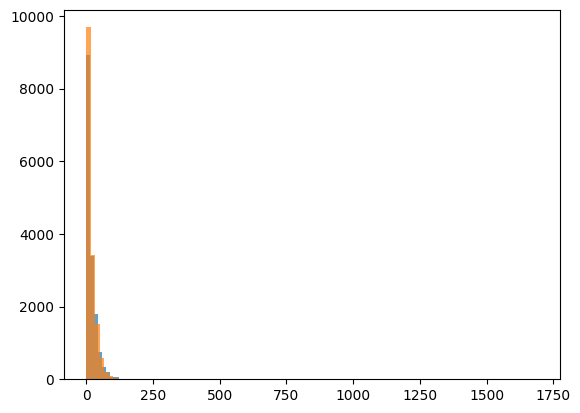

In [15]:
plt.hist(df["levenshtein_l"], alpha=0.7, bins=100)
plt.hist(df["levenshtein_xl"], alpha=0.7, bins=100)
plt.show()

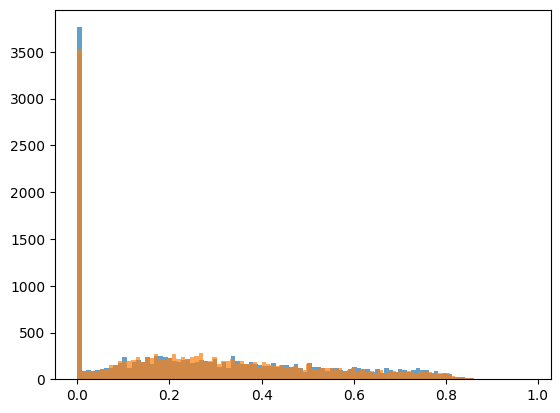

In [16]:
plt.hist(df["levenshtein_norm_l"], alpha=0.7, bins=100)
plt.hist(df["levenshtein_norm_xl"], alpha=0.7, bins=100)
plt.show()

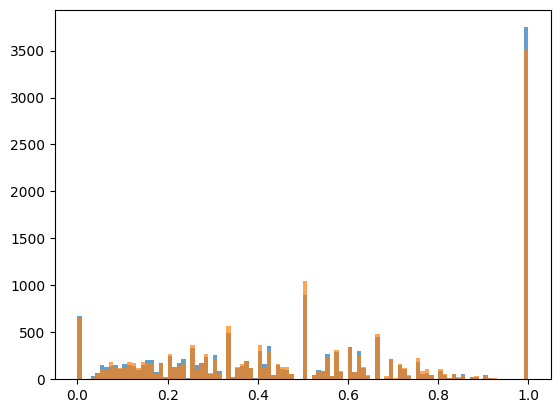

In [43]:
plt.hist(df["jaccard_bigram_l"], alpha=0.7, bins=100)
plt.hist(df["jaccard_bigram_xl"], alpha=0.7, bins=100)
plt.show()

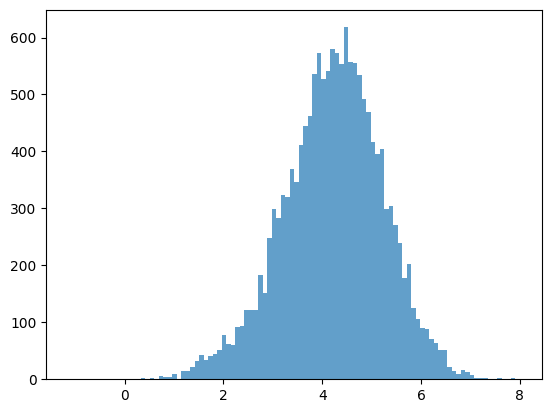

In [42]:
plt.hist(df["bpeslor"], alpha=0.7, bins=100)
plt.show()

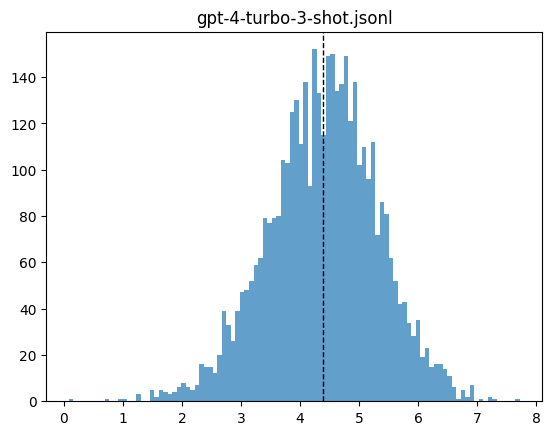

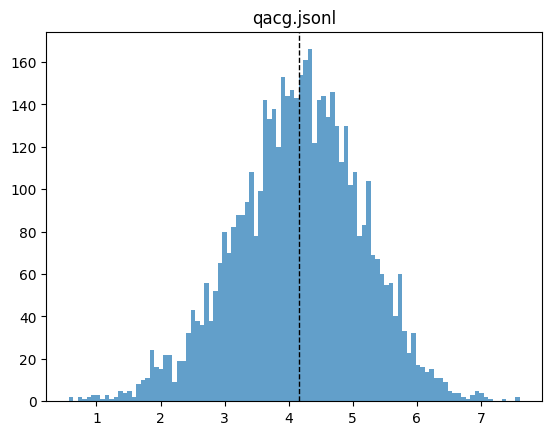

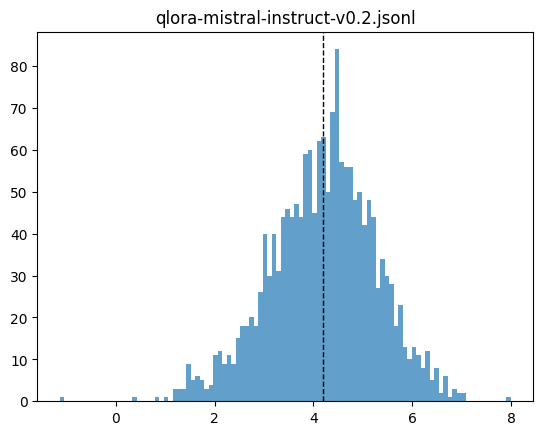

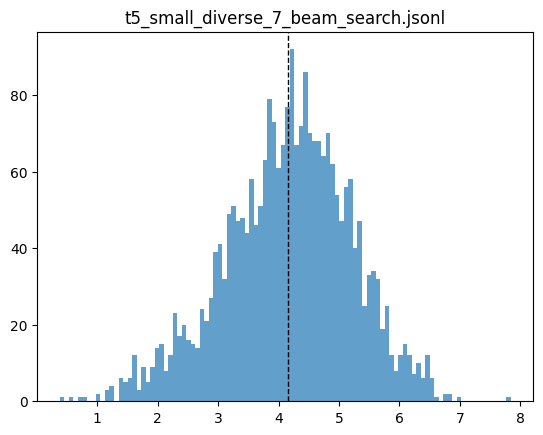

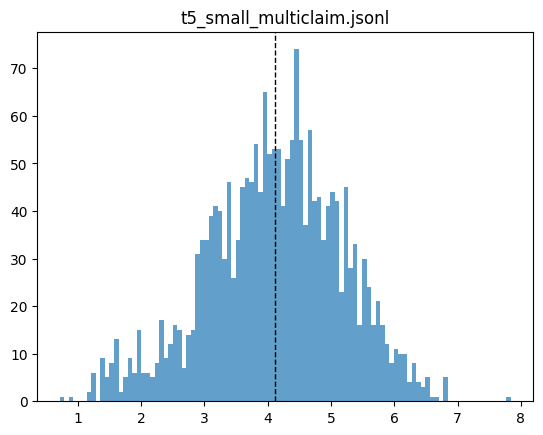

In [49]:
for model in MODELS:
    tmp_df = df[df["model_name"] == model[:-6]]
    plt.title(model)
    plt.axvline(tmp_df["bpeslor"].mean(), color='k', linestyle='dashed', linewidth=1)
    plt.hist(tmp_df["bpeslor"], alpha=0.7, bins=100, )
    plt.show()

In [61]:
for model in MODELS:
    tmp_df = df[df["model_name"] == model[:-6]]
    uniques_l, counts_l = np.unique(tmp_df["scribendi_score_l"].to_numpy(), return_counts = True)
    percentages_l = dict(zip(uniques_l, counts_l * 100 / len(tmp_df["scribendi_score_l"].to_numpy())))
    print(model, "scribendi_score_l","\n  ", uniques_l, "\n  ", counts_l,"\n  ", percentages_l)
    
    uniques_xl, counts_xl = np.unique(tmp_df["scribendi_score_xl"].to_numpy(), return_counts = True)
    percentages_xl = dict(zip(uniques_xl, counts_xl * 100 / len(tmp_df["scribendi_score_xl"].to_numpy())))
    print(model, "scribendi_score_xl","\n  ", uniques_xl, "\n  ", counts_xl,"\n  ", percentages_xl)

gpt-4-turbo-3-shot.jsonl scribendi_score_l 
   [-1  0  1] 
   [1887 1029 1221] 
   {-1: 45.61276287164612, 0: 24.873096446700508, 1: 29.514140681653373}
gpt-4-turbo-3-shot.jsonl scribendi_score_xl 
   [-1  0  1] 
   [1743 1052 1342] 
   {-1: 42.131979695431475, 0: 25.429054870679238, 1: 32.438965433889294}
qacg.jsonl scribendi_score_l 
   [-1  0  1] 
   [2570  937 1610] 
   {-1: 50.22474105921438, 0: 18.311510650771936, 1: 31.46374829001368}
qacg.jsonl scribendi_score_xl 
   [-1  0  1] 
   [2314 1087 1716] 
   {-1: 45.221809654094194, 0: 21.242915770959545, 1: 33.53527457494626}
qlora-mistral-instruct-v0.2.jsonl scribendi_score_l 
   [-1  0  1] 
   [824 467 437] 
   {-1: 47.68518518518518, 0: 27.025462962962962, 1: 25.28935185185185}
qlora-mistral-instruct-v0.2.jsonl scribendi_score_xl 
   [-1  0  1] 
   [794 355 579] 
   {-1: 45.949074074074076, 0: 20.54398148148148, 1: 33.50694444444444}
t5_small_diverse_7_beam_search.jsonl scribendi_score_l 
   [-1  0  1] 
   [1151  714  651] 
   {-

In [60]:
for model in MODELS:
    tmp_df = df[df["model_name"] == model[:-6]]
    uniques_l, counts_l = np.unique(tmp_df["identity_l"].to_numpy(), return_counts = True)
    percentages_l = dict(zip(uniques_l, counts_l * 100 / len(tmp_df["identity_l"].to_numpy())))
    print(model, "identity_l","\n  ", uniques_l, "\n  ", counts_l,"\n  ", percentages_l)
    
    uniques_xl, counts_xl = np.unique(tmp_df["identity_xl"].to_numpy(), return_counts = True)
    percentages_xl = dict(zip(uniques_xl, counts_xl * 100 / len(tmp_df["identity_xl"].to_numpy())))
    print(model, "identity_xl","\n  ", uniques_xl, "\n  ", counts_xl,"\n  ", percentages_xl)

gpt-4-turbo-3-shot.jsonl identity_l 
   [False  True] 
   [3108 1029] 
   {False: 75.1269035532995, True: 24.873096446700508}
gpt-4-turbo-3-shot.jsonl identity_xl 
   [False  True] 
   [3085 1052] 
   {False: 74.57094512932076, True: 25.429054870679238}
qacg.jsonl identity_l 
   [False  True] 
   [4180  937] 
   {False: 81.68848934922806, True: 18.311510650771936}
qacg.jsonl identity_xl 
   [False  True] 
   [4030 1087] 
   {False: 78.75708422904046, True: 21.242915770959545}
qlora-mistral-instruct-v0.2.jsonl identity_l 
   [False  True] 
   [1261  467] 
   {False: 72.97453703703704, True: 27.025462962962962}
qlora-mistral-instruct-v0.2.jsonl identity_xl 
   [False  True] 
   [1373  355] 
   {False: 79.45601851851852, True: 20.54398148148148}
t5_small_diverse_7_beam_search.jsonl identity_l 
   [False  True] 
   [1802  714] 
   {False: 71.62162162162163, True: 28.37837837837838}
t5_small_diverse_7_beam_search.jsonl identity_xl 
   [False  True] 
   [1954  562] 
   {False: 77.66295707472

## Outliers?

In [3]:
df.describe()
# there seems to be outliers (especially in levenshtein distance)

,sentence_id,pplxt_claim,pplxt_claim_coedit_l,pplxt_claim_coedit_xl,bpeslor,scribendi_score_l,scribendi_score_xl,jaccard_bigram_l,levenshtein_l,levenshtein_xl,jaccard_bigram_xl
count,15475.000000,15475.000000,15475.000000,15475.000000,15475.000000,15475.000000,15475.000000,15475.000000,15475.000000,15475.000000,15475.000000
mean,3167.961551,115.714151,92.929072,81.793272,4.218817,-0.189661,-0.098288,0.533455,18.389596,17.424426,0.532738
std,1899.615163,299.789818,633.345959,182.877232,1.007236,0.849634,0.874048,0.330950,26.638842,35.613316,0.324273
min,4.000000,4.620808,1.274006,1.401227,-1.134594,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000
25%,1475.000000,33.077827,27.038853,25.865503,3.581184,-1.000000,-1.000000,0.250000,1.000000,3.000000,0.264912
50%,3150.000000,58.696835,47.612183,45.408848,4.262376,0.000000,0.000000,0.500000,12.000000,12.000000,0.500000
75%,4831.000000,114.104122,90.741795,83.996140,4.902826,1.000000,1.000000,0.866667,27.000000,25.000000,0.800000
max,6671.000000,24376.843750,75713.343750,11399.109375,7.995834,1.000000,1.000000,1.000000,1518.000000,1689.000000,1.000000


In [5]:
df[df["levenshtein_xl"] > 500]

,model_name,sentence_id,claim,claim_coedit_l,claim_coedit_xl,pplxt_claim,pplxt_claim_coedit_l,pplxt_claim_coedit_xl,identity_l,identity_xl,bpeslor,scribendi_score_l,scribendi_score_xl,jaccard_bigram_l,levenshtein_l,levenshtein_xl,jaccard_bigram_xl
1612,gpt-4-turbo-3-shot,697,Ecuador is bordered by Colombia to the north.,It is bordered by Colombia to the north.,"It is bordered by Colombia to the north, by Ec...",36.405491,47.665611,1.567478,False,False,4.862320,-1,-1,0.750000,7,1672,0.156250
3530,gpt-4-turbo-3-shot,5615,Lithuania is bordered by Latvia to the north.,It is bordered by Latvia to the north.,"It is bordered by Latvia to the north, by Esto...",24.281214,57.896843,1.401227,False,False,5.152670,-1,-1,0.750000,8,1689,0.208333
6609,qacg,26,"Along with Costa Rica, Nicaragua, Honduras, Ja...",The Dominican Republic shares its maritime bor...,The country is bordered by Colombia to the nor...,16.280565,63.666584,1.936552,False,False,5.537860,-1,-1,0.368421,74,1575,0.017241
6752,qacg,5881,"Along with Iraq, Turkey borders Iran to the west.","Turkey borders Iran to the west, with Iraq.","Turkey is bordered by Iran to the west, by Ira...",66.714912,101.354881,1.493210,False,False,3.287202,-1,-1,0.363636,28,1469,0.051282
9920,qlora-mistral-instruct-v0.2,697,Ecuador is bordered by Colombia on the north.,It is bordered by Colombia to the north.,"It is bordered by Colombia to the north, by Ec...",53.086361,47.665611,1.557766,False,False,4.601037,1,-1,0.400000,9,1683,0.090909
10096,qlora-mistral-instruct-v0.2,26,Colombia borders Venezuela to the east.,Colombia borders Venezuela to the east.,"Colombia is bordered by Venezuela to the east,...",47.471256,47.464035,1.952789,True,False,4.494808,0,-1,1.000000,0,1301,0.052632


In [11]:
display(df.loc[3530])
display(df.loc[3530]["claim"])
display(df.loc[3530]["claim_coedit_l"])
display(df.loc[3530]["claim_coedit_xl"])

model_name                                              gpt-4-turbo-3-shot
sentence_id                                                           5615
claim                        Lithuania is bordered by Latvia to the north.
claim_coedit_l                      It is bordered by Latvia to the north.
claim_coedit_xl          It is bordered by Latvia to the north, by Esto...
pplxt_claim                                                      24.281214
pplxt_claim_coedit_l                                             57.896843
pplxt_claim_coedit_xl                                             1.401227
identity_l                                                           False
identity_xl                                                          False
bpeslor                                                            5.15267
scribendi_score_l                                                       -1
scribendi_score_xl                                                      -1
jaccard_bigram_l         

'Lithuania is bordered by Latvia to the north.'

'It is bordered by Latvia to the north.'

'It is bordered by Latvia to the north, by Estonia to the north, by Kaliningrad to the north, by Lithuania to the north, by Russia to the north, by Belarus to the north, by Ukraine to the north, by Belarus to the north, by Russia to the north, by Lithuania to the north, by Latvia to the north, by Estonia to the north, by Lithuania to the north, by Latvia to the north, by Poland to the north, by Lithuania to the north, by Latvia to the north, by Lithuania to the north, by Latvia to the north, by Lithuania to the north, by Latvia to the north, by Lithuania to the north, by Latvia to the north, by Lithuania to the north, by Latvia to the north, by Lithuania to the north, by Latvia to the north, by Lithuania to the north, by Lithuania to the north, by Latvia to the north, by Lithuania to the north, by Latvia to the north, by Lithuania to the north, by Lithuania to the north, by Lithuania to the north, by Lithuania to the north, by Lithuania to the north, by Lithuania to the north, by Lithu

on l

In [12]:
df[df["levenshtein_l"] > 500]

,model_name,sentence_id,claim,claim_coedit_l,claim_coedit_xl,pplxt_claim,pplxt_claim_coedit_l,pplxt_claim_coedit_xl,identity_l,identity_xl,bpeslor,scribendi_score_l,scribendi_score_xl,jaccard_bigram_l,levenshtein_l,levenshtein_xl,jaccard_bigram_xl
873,gpt-4-turbo-3-shot,5811,Ridley Scott renewed interest in Prometheus in...,Scott continued to be interested in Prometheus...,Ridley Scott announced in 2009 that he is inte...,93.650955,1.642539,25.240993,False,False,3.827415,-1,-1,0.057143,1518,43,0.055556
918,gpt-4-turbo-3-shot,515,Akshay Kumar is a leading contemporary actor o...,Akshay Kumar is a contemporary Indian actor of...,Akshay Kumar is an Indian actor. He is known f...,30.431709,1.554742,10.959998,False,False,5.418045,-1,-1,0.240000,626,38,0.095238
4229,qacg,134,Wiz Khalifa is American.,He is also a a sac ac he is a ac he is a ac he...,Wiz Khalifa is an American rapper.,59.552326,1.563849,18.524075,False,False,4.430948,-1,1,0.000000,536,10,0.333333
11029,t5_small_diverse_7_beam_search,134,Wiz Khalifa is American.,He is also a a sac ac he is a ac he is a ac he...,Wiz Khalifa is an American rapper.,59.552326,1.563849,18.524075,False,False,4.430948,-1,1,0.000000,536,10,0.333333
12195,t5_small_diverse_7_beam_search,5746,James McAvoy won a Golden Globe Award.,James McAvoy won a Golden Globe Award for Best...,James McAvoy won a Golden Globe Award.,33.899315,1.274006,33.895569,False,True,5.830342,-1,0,0.312500,1176,0,1.000000


In [13]:
display(df.loc[873])
display(df.loc[873]["claim"])
display(df.loc[873]["claim_coedit_l"])
display(df.loc[873]["claim_coedit_xl"])

model_name                                              gpt-4-turbo-3-shot
sentence_id                                                           5811
claim                    Ridley Scott renewed interest in Prometheus in...
claim_coedit_l           Scott continued to be interested in Prometheus...
claim_coedit_xl          Ridley Scott announced in 2009 that he is inte...
pplxt_claim                                                      93.650955
pplxt_claim_coedit_l                                              1.642539
pplxt_claim_coedit_xl                                            25.240993
identity_l                                                           False
identity_xl                                                          False
bpeslor                                                           3.827415
scribendi_score_l                                                       -1
scribendi_score_xl                                                      -1
jaccard_bigram_l         

'Ridley Scott renewed interest in Prometheus in 2009.'

'Scott continued to be interested in Prometheus in 2009, and in 2010 he made a new discovery, the discovery of the ring-shaped sphere of the moon Prometheus A. Scott continued to be interested in Prometheus in 2009, and in 2010 he made another discovery, the discovery of the ring-shaped sphere of the moon Prometheus A. Scott continued to be interested in Prometheus in 2009, and in 2010 he made another discovery, the discovery of the ring-shaped sphere of the moon Prometheus A. Scott continued to be interested in Prometheus in 2009, and in 2010 he made another discovery, the discovery of the ring-shaped sphere of the moon Prometheus A. Scott continued to be interested in Prometheus in 2009, and in 2010 he made another discovery, the discovery of the ring-shaped sphere of the moon Prometheus A. Scott continued to be interested in Prometheus in 2009, and in 2010 he made another discovery, the discovery of the ring-shaped sphere of the moon Prometheus A. Scott continued to be interested in

'Ridley Scott announced in 2009 that he is interested in reprising the role.'

## 💾 Save Data

In [15]:
df.to_json(os.path.join(DATA_PATH, "fluency_final_results_perplexity_compare.jsonl"), orient="records", lines=True)